In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import norm
import math
from sklearn.decomposition import PCA
from kymatio.numpy import Scattering1D
import cmath 

In [2]:
params    = ['vel',   'logN' ,  'b']
fid_valus = [0.0 , 12.8 , 5.0]
diffs     = [0.2 , 0.02 , 0.35]
param_num = 3

In [3]:
# function to get fisher matrrix, requires inverse of cov matrix and derivative.
def get_fisher_matrix(Icov, dervs):
    Fisher = np.zeros((param_num, param_num), dtype=np.float64)
    for i in range(param_num):
        for j in range(i, param_num):
            if i==j:
                Fisher[i,j] = np.dot(dervs[i], np.dot(Icov, dervs[i]))
            else:
                Fisher[i,j] = 0.5*(np.dot(dervs[i], np.dot(Icov, dervs[j])) + np.dot(dervs[j], np.dot(Icov, dervs[i])))
                Fisher[j,i] = Fisher[i,j]
    return Fisher

In [4]:
def a2(sx, sy, sxy):
    return 0.5*(sx + sy) + np.sqrt(  (sx - sy)**2.0/4. + sxy**2.)
def b2(sx, sy, sxy):
    return 0.5*(sx + sy) - np.sqrt(  (sx - sy)**2.0/4. + sxy**2.)
def angle(sx, sy, sxy):
    return 0.5*np.arctan2(2.0*sxy, sy-sx)

def elp_coor(fish_inv, dx1,dx2,sig):
        a      = np.sqrt( a2(fish_inv[dx1,dx1],fish_inv[dx2,dx2], fish_inv[dx1,dx2]) )*sig
        b      = np.sqrt( b2(fish_inv[dx1,dx1],fish_inv[dx2,dx2], fish_inv[dx1,dx2]) )*sig
        theta  = angle(fish_inv[dx1,dx1],fish_inv[dx2,dx2], fish_inv[dx1,dx2]) 
        return a,b,theta

# QSOs specs


In [96]:
spec_all  = np.loadtxt('OneCloud/specs_10k_fiducial_params/MgII2796data.txt')
pos_all   = np.zeros((3, 500, 450), dtype=np.float64)
neg_all   = np.zeros((3, 500, 450), dtype=np.float64)
for i in range(3):
    pos_all[i]   = np.loadtxt('OneCloud/specs_500_'+params[i]+'_pos/MgII2796data.txt')
    neg_all[i]   = np.loadtxt('OneCloud/specs_500_'+params[i]+'_neg/MgII2796data.txt')

In [97]:
spec_all.shape

(10000, 450)

In [98]:
s1, s2 = 210, 240

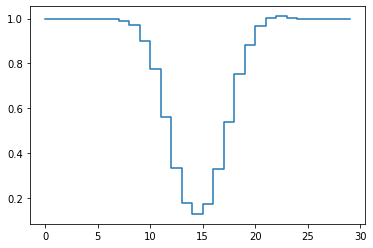

In [99]:
plt.close()
plt.step(range(spec_all[:,s1:s2].shape[1]),spec_all[100][s1:s2])
plt.show()

In [100]:
spec_all[:,s1:s2].shape

(10000, 30)

(30, 30) (10000, 450)
cond 170.99255420519026
det -271.21354209131243 1.0


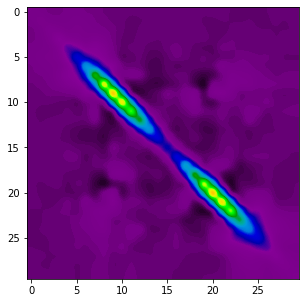

0.0006448533737042462 -2.9199507801234116e-05


In [101]:
cov_spec   = np.cov(spec_all[:,s1:s2], rowvar=False)

print (cov_spec.shape, spec_all.shape)
print ('cond', np.linalg.cond(cov_spec))
sign, logdet = np.linalg.slogdet(cov_spec)
print ('det', logdet, sign  )

fig, ax = plt.subplots(1, figsize=(7,5))
ax.imshow(cov_spec,interpolation='gaussian', cmap='nipy_spectral')
plt.show()
print (np.max(cov_spec), np.min(cov_spec))

In [102]:
#corr = np.zeros(cov_spec.shape)
#for i in range(30):
#    for j in range(30):
#        corr[i,j]  =  cov_spec[i,j] / np.sqrt(cov_spec[i,i]*cov_spec[j,j])

In [103]:
#print (np.max(corr), np.min(corr))

1.0 -0.056480173310369586


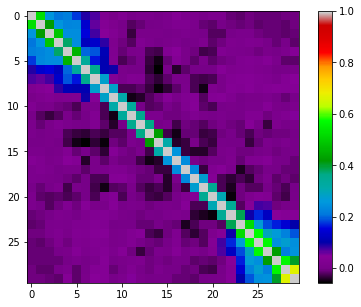

In [104]:
corr = np.corrcoef(spec_all[:,s1:s2], rowvar=False)
print (np.max(corr), np.min(corr))
fig, ax = plt.subplots(1, figsize=(7,5))
cs = ax.imshow(corr, cmap='nipy_spectral')
plt.colorbar(cs)
plt.show()


In [105]:
cov_spec.shape[0]

30

In [106]:
dervs     = np.zeros((3, cov_spec.shape[0]), dtype=np.float64)
#dervs2  = np.zeros((3, cov_spec.shape[0]), dtype=np.float64)
#dervs3     = np.zeros((3, cov_spec.shape[0]), dtype=np.float64)
for i in range(3):
    pos   = pos_all[i,:,s1:s2]
    neg   = neg_all[i,:,s1:s2]
    Yp,Ym = np.mean(pos, axis=0), np.mean(neg, axis=0)
    dervs[i]   = (Yp - Ym)/(2.0*diffs[i])

In [107]:
dervs.shape

(3, 30)

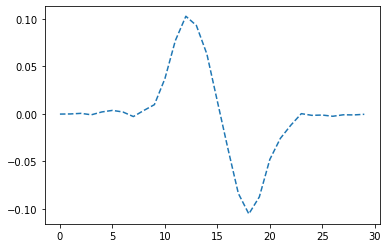

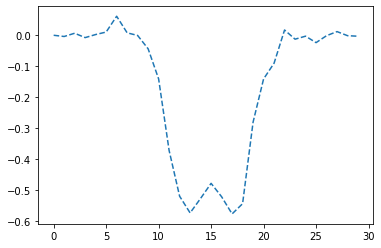

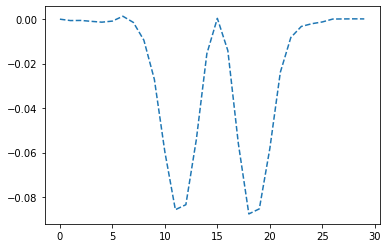

In [108]:
for i in range(3):
    plt.plot(range(dervs.shape[1]), dervs[i], '--')
    #plt.plot(range(dervs2.shape[1]), dervs2[i], '-')
#    plt.plot(range(dervs3.shape[1]), dervs3[i], '-.')
    plt.show()

In [109]:
Icov_spec      = np.linalg.inv(cov_spec)
Fisher_spec    = get_fisher_matrix(Icov_spec, dervs)
IFisher_spec   = np.linalg.inv(Fisher_spec)

#  pca

In [176]:
pca       = PCA(0.999).fit( spec_all[:,s1:s2] )
projected = pca.transform( spec_all[:,s1:s2] )

In [177]:
projected.shape

(10000, 29)

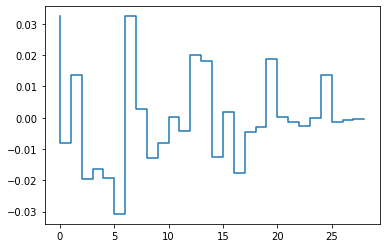

In [178]:
plt.close()
plt.step(range(projected.shape[1]),projected[1500])
plt.show()

(29, 29) (10000, 29)
cond 154.29792563163105
det -259.1090351554077 1.0


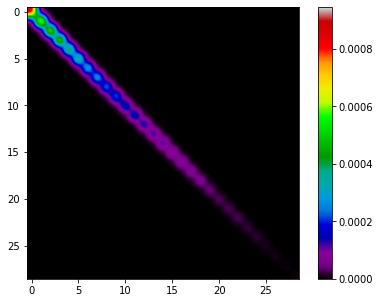

In [179]:
cov_pca = np.cov(projected, rowvar=False)
print (cov_pca.shape,projected.shape)
print ('cond', np.linalg.cond(cov_pca))
sign, logdet = np.linalg.slogdet(cov_pca)
print ('det', logdet,sign )
fig, ax = plt.subplots(1, figsize=(7,5))
cs = ax.imshow(cov_pca,interpolation='gaussian', cmap='nipy_spectral')
plt.colorbar(cs)
plt.show()

1.0 -1.3633417026583846e-15


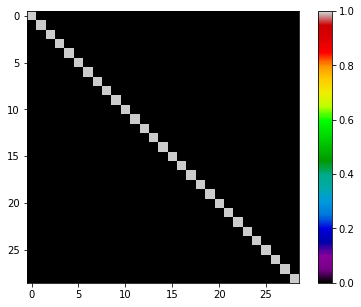

In [180]:
corr = np.corrcoef(projected, rowvar=False)
print (np.max(corr), np.min(corr))
fig, ax = plt.subplots(1, figsize=(7,5))
cs = ax.imshow(corr, cmap='nipy_spectral')
plt.colorbar(cs)
plt.show()

In [181]:
dervsp   = np.zeros((3, cov_pca.shape[0]), dtype=np.float64)
for i in range(3):
    pos   = pos_all[i,:,s1:s2]
    pos   = pca.transform(  pos )
    neg   = neg_all[i,:,s1:s2]                                              
    neg   = pca.transform( neg)
    Yp,Ym = np.mean(pos, axis=0), np.mean(neg, axis=0)
    dervsp[i]   = (Yp - Ym)/(2.0*diffs[i])

In [182]:
Icov_pca       = np.linalg.inv(cov_pca)
Fisher_pca     = get_fisher_matrix(Icov_pca, dervsp)
IFisher_pca    = np.linalg.inv(Fisher_pca)

# wavelets

In [183]:

#1,6===3,16, nan 1,7

In [184]:

#meta = scattering.meta()
#order0 = np.where(meta['order'] == 0)
#order1 = np.where(meta['order'] == 1)
#order2 = np.where(meta['order'] == 2)
#order3 = np.where(meta['order'] == 3)

In [216]:
T = spec_all[:,s1:s2].shape[-1]
J =  1
Q = 7
scattering = Scattering1D(J, T, Q)
sc  = scattering(spec_all[:,s1:s2])
sc  = sc[:,1:,:].reshape(sc.shape[0],-1)
#sc  = np.log10(  np.abs(sc) + 1.e-6  )

In [217]:
sc.shape

(10000, 90)

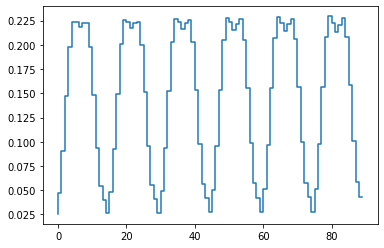

In [218]:
plt.close()
plt.step(range(sc.shape[1]),sc[10])
plt.show()

(90, 90) (10000, 90)
cond == 3.202164e+18
det -3209.3642408171313 -1.0


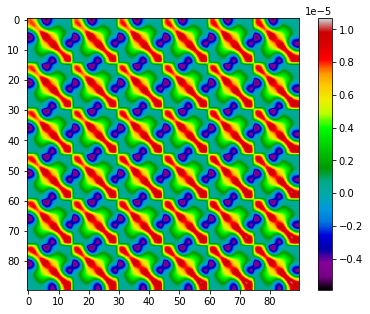

In [219]:
cov_sc = np.cov(sc, rowvar=False)
print (cov_sc.shape,sc.shape)
print ('cond == %e' % np.linalg.cond(cov_sc))
sign, logdet = np.linalg.slogdet(cov_sc)
print ('det', logdet , sign )
fig, ax = plt.subplots(1, figsize=(7,5))
cs = ax.imshow(cov_sc,interpolation='gaussian', cmap='nipy_spectral')
plt.colorbar(cs)
plt.show()

1.0 -0.6627359114494777


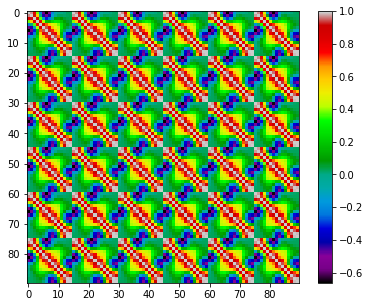

In [220]:
corr = np.corrcoef(sc, rowvar=False)
print (np.max(corr), np.min(corr))
fig, ax = plt.subplots(1, figsize=(7,5))
cs = ax.imshow(corr, cmap='nipy_spectral')
plt.colorbar(cs)
plt.show()

In [221]:
dervsc   = np.zeros((3, cov_sc.shape[0]), dtype=np.float64)
for i in range(3):
    pos   = scattering(pos_all[i,:,s1:s2])
    pos   = pos[:,1:,:].reshape(pos.shape[0],-1)
    #pos   = np.log10(  np.abs(pos) + 1.e-6  )
    

    neg   = scattering(neg_all[i,:,s1:s2])
    neg   = neg[:,1:,:].reshape(neg.shape[0],-1)
    #neg   = np.log10(  np.abs(neg) + 1.e-6  )
    
    Yp,Ym = np.mean(pos, axis=0), np.mean(neg, axis=0)
    dervsc[i]   = (Yp - Ym)/(2.0*diffs[i])

Icov_sc        = np.linalg.inv(cov_sc)
Fisher_sc      = get_fisher_matrix(Icov_sc, dervsc)
IFisher_sc     = np.linalg.inv(Fisher_sc)

# results...

In [222]:
for i in range(3):
    print ('Error on %03s = %e %e %e' %(params[i], np.sqrt(IFisher_spec[i,i]),  np.sqrt(IFisher_pca[i,i]),  np.sqrt(IFisher_sc[i,i])) )
    
    

Error on vel = 8.913080e-02 8.913144e-02 7.457903e-02
Error on logN = 1.558648e-02 1.558666e-02 1.154781e-02
Error on   b = 1.596362e-01 1.597158e-01 7.518064e-02


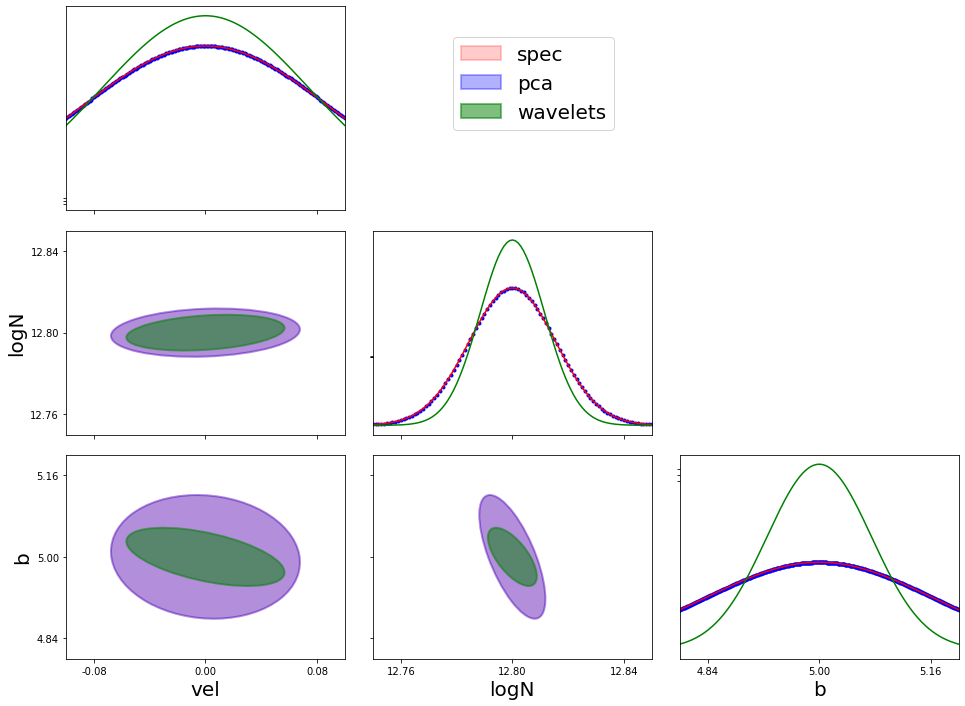

In [223]:
lims_ax = [[-0.1,0.1],[12.75, 12.85], [4.8, 5.2]]

tr      = np.linspace(0,8,9).reshape(3,3)
xi, yi  = np.triu_indices_from(tr, k=1)
fig, ax = plt.subplots(3,3, figsize = (16,12))#,  constrained_layout=True)
for i in range(3):
    for j in range(3):
 
        fr1 = (lims_ax[j][1] - lims_ax[j][0])/10.0
        tt1 = np.linspace(lims_ax[j][0]+fr1,lims_ax[j][1]-fr1, 3)
        fr2 = (lims_ax[i][1] - lims_ax[i][0])/10.0
        tt2 = np.linspace(lims_ax[i][0]+fr2,lims_ax[i][1]-fr2, 3)
 
        
        if i==j:
            ax[i,i].set_yticklabels([])
            ax[i,i].set_xlim(lims_ax[j])
            if i < 2:
                ax[i,i].set_xticklabels([])
            else:
                ax[i,j].set_xlabel(params[i],  fontsize=20)
            ax[i,i].set_xticks(tt1)
            ax[i,j].set_yticks(tt2)
            
            xp  = np.arange(lims_ax[i][0]-0.5, lims_ax[i][1]+0.5, 0.001)
            
            yp  = norm.pdf(xp,fid_valus[i],np.sqrt(IFisher_pca[i,i]))
            ax[i,i].plot(xp,yp, 'b.')
            yp  = norm.pdf(xp,fid_valus[i],np.sqrt(IFisher_spec[i,i]))
            ax[i,i].plot(xp,yp, 'r')
            
            yp  = norm.pdf(xp,fid_valus[i],np.sqrt(IFisher_sc[i,i]))
            ax[i,i].plot(xp,yp, 'g')
            
            continue
            
        ax[i,j].set_xlim(lims_ax[j])
        ax[i,j].set_ylim(lims_ax[i])    
        if i+j*3 in xi+yi*3:
                    ax[i,j].axis('off')
                    continue

        xcenter, ycenter = fid_valus[j], fid_valus[i]
        a,b,theta        = elp_coor(IFisher_spec, i,j,1.52)
        #print ("spec", i, j , a, b)
        e1               = Ellipse( (xcenter, ycenter) ,  a, b, np.degrees(theta), linewidth=2, alpha=0.2, fill=True, color='r',  label= 'spec')
        ax[i,j].add_patch(e1)
        a,b,theta        = elp_coor(IFisher_pca, i,j,1.52)
        #print ("pca", i, j , a, b)
        e2               = Ellipse( (xcenter, ycenter) ,  a, b, np.degrees(theta), linewidth=2,  alpha=0.3, fill=True, color='b',  label= 'pca')
        ax[i,j].add_patch(e2)
        
        a,b,theta        = elp_coor(IFisher_sc, i,j,1.52)
        #print ("sc", i, j , a, b, b2(IFisher_sc[i,i], IFisher_sc[j,j], IFisher_sc[i,j]), IFisher_sc[i,i], IFisher_sc[j,j], IFisher_sc[i,j])
        e2               = Ellipse( (xcenter, ycenter) ,  a, b, np.degrees(theta), linewidth=2,  alpha=0.5, fill=True, color='g',  label= 'wavelets')
        ax[i,j].add_patch(e2)

        
        ax[i,j].set_xticks(tt1)
        if j==0:
            ax[i,j].set_ylabel(params[i],  fontsize=20)
            ax[i,j].set_yticklabels([ "%.2f" % lb for lb in tt2  ])
        else:
            ax[i,j].set_yticklabels([])
        ax[i,j].set_yticks(tt2)
        if i==2:
            ax[i,j].set_xlabel(params[j],  fontsize=20)
            ax[i,j].set_xticklabels([ "%.2f" % lb for lb in tt1  ])
        else:
            ax[i,j].set_xticklabels([])

        if i==1:
            ax[i,j].legend(bbox_to_anchor=(2, 2), fontsize=20)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
